<b>Demonstration of Local Dupire Model and Monte Carlo calibration of the Leverage</b>
<br>
<br>
the implementation follows the instructions from:<br>
<i>https://quant.stackexchange.com/questions/44300/mixed-local-stochastic-volatility-model-in-quantlib</i>

some functions to plot and perform the MC calibration

In [1]:
import QuantLib as ql
import math
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd
import itertools

from scipy.stats import norm

# Some utility functions used later to plot 3D vol surfaces, generate paths, and generate vol surface from Heston params

def plot_vol_surface(vol_surface, funct='blackVol'):
    if type(vol_surface) != list:
        surfaces = [vol_surface]
    else:
        surfaces = vol_surface

    plot_years = np.arange(max(daysaddasint_unique)/365.0, min(daysaddasint_unique)/365.0, -0.01) # Values in descending order
    plot_strikes = np.arange(max(strikes_unique), min(strikes_unique), -100) # Values in ascending order


    fig = plt.figure(figsize=(12, 6))


    ax = plt.subplot(111, projection='3d')

    X, Y = np.meshgrid(plot_strikes, plot_years)
   

    for surface in surfaces:
        method_to_call = getattr(surface, funct)

        Z = np.array([method_to_call(float(y), float(x)) 
                      for xr, yr in zip(X, Y) 
                      for x, y in zip(xr, yr)]
                    ).reshape(X.shape[0], X[0].size)

        surf = ax.plot_surface(X, Y, Z, cmap = 'coolwarm')

    #ax.invert_xaxis()
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
   
    logmoneyness = np.round(np.arange(-0.15, 0.16, 0.05),2)
    strikepoints = np.exp(logmoneyness)*spot
    #replace the lables at the x-axis with the strikes divided by moneynes but keep the lables at original position
    ax.set_xticks(strikepoints,logmoneyness)
    #set axis titles
    ax.set_xlabel('Log Moneyness')
    ax.set_ylabel('Time to Maturity (years)')    

    
    #ax.elev = 13
    
    plt.tight_layout()
    ax.invert_yaxis()  # Invert the y-axis to display values ascending from left to right
    plt.show()

def generate_multi_paths_df(sequence, num_paths):
    spot_paths = []
    vol_paths = []

    for i in range(num_paths):
        sample_path = seq.next()
        values = sample_path.value()


        spot, vol = values

        spot_paths.append([x for x in spot])
        vol_paths.append([x for x in vol])

    df_spot = pd.DataFrame(spot_paths, columns=[spot.time(x) for x in range(np.array(spot).size)])
    df_vol = pd.DataFrame(vol_paths, columns=[spot.time(x) for x in range(np.array(spot).size)])

    return df_spot, df_vol

def create_vol_surface_mesh_from_heston_params(today, calendar, spot, v0, kappa, theta, rho, sigma, 
                                               rates_curve_handle, dividend_curve_handle,
                                               strikes = np.linspace(40, 200, 161), tenors = np.linspace(0.1, 3, 60)):
    quote = ql.QuoteHandle(ql.SimpleQuote(spot))

    heston_process = ql.HestonProcess(rates_curve_handle, dividend_curve_handle, quote, v0, kappa, theta, sigma, rho)
    heston_model = ql.HestonModel(heston_process)
    heston_handle = ql.HestonModelHandle(heston_model)
    heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

    data = []
    for strike in strikes:
        data.append([heston_vol_surface.blackVol(tenor, strike) for tenor in tenors])

    expiration_dates = [calendar.advance(today, ql.Period(int(365*t), ql.Days)) for t in tenors]
    implied_vols = ql.Matrix(data)
    feller = 2 * kappa * theta - sigma ** 2

    return expiration_dates, strikes, implied_vols, feller


Loading the data and arranging to grid

In [2]:
import QuantLib as ql
import math
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
from datetime import date, datetime

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm





dates, percent = helpers.init()

df1 = helpers.load_month(2023,3,'SPX')
df1,len = helpers.split_days(df1, num_groups = 1)
df = df1[len-1]

spot = int(helpers.get_underlyinglast(df))

daysaddasint = np.round(np.array(helpers.get_daystomaturity(df))/30)*30
strikes = np.round(np.array(helpers.get_strike(df))/100)*100

implied_vols = np.array(helpers.get_IV_C(df))
prices = np.array(helpers.get_callprice(df))
year, month, day = helpers.get_pricingdate(df)
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates(ql.UnitedStates.Settlement)
#year, month, day = helpers.get_pricingdate(df)   
#                           
calculation_date = ql.Date(day, month, year)

    


dividend_rate = 0.00
risk_free_rate = helpers.get_interestrate(year, month, day, dates, percent)#, daysaddasint/365.0)
dividend_yield = ql.QuoteHandle(ql.SimpleQuote(dividend_rate))

ql.Settings.instance().evaluationDate = calculation_date

#gut: 0.9-1.1 and 30-120 days no div yield

down = 0.84
up = 1.16

filter1 = strikes > down*spot
filter2 = strikes < up*spot
filter3 = daysaddasint > 0
filter4 = daysaddasint <= 368
filter5 = implied_vols > 0.1*np.mean(implied_vols)

filter = filter1 & filter2 & filter3 & filter4 & filter5

implied_vols = implied_vols[filter].flatten()
strikes = strikes[filter].flatten()
daysaddasint = daysaddasint[filter].flatten().astype(int)
prices = prices[filter].flatten()
daysaddasint_unique = sorted(np.unique(daysaddasint))

daysaddasint = pd.Series(daysaddasint)


calculation_date_ts = pd.Timestamp(calculation_date.year(), calculation_date.month(), calculation_date.dayOfMonth())

# Add business days to the Pandas timestamp
py_date = daysaddasint.apply(lambda x: calculation_date_ts + pd.tseries.offsets.BusinessDay(x))




flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count))


#apply date() to all py_date, use map as it is faster than apply
py_date = list(map(datetime.date, py_date))

# Convert Python date to ql.Date
expiration_dates = [ql.Date(d.day, d.month, d.year) for d in py_date]



consolidated = pd.DataFrame({'Strike': strikes, 'Time to Maturity': expiration_dates, 'Implied Volatility': implied_vols})
#only use rows and cols with strikes > 0.8*spot and < 1.2*spot and maturities > 0.0 and < 1.0

#use mean in case of dublicates
consolidated = consolidated.groupby(['Strike', 'Time to Maturity']).mean().reset_index()


# Pivot the dataframe to create the matrix
volmatrix = consolidated.pivot(index='Strike', columns='Time to Maturity', values='Implied Volatility')

#remove interpolation later, only use for plotting
volmatrix = volmatrix.interpolate(method='quadratic')



rows, cols = volmatrix.shape
implied_vola = ql.Matrix(rows, cols)

# fill the matrix with the values from the pivot table
for i in range(rows):
    for j in range(cols):
        value = volmatrix.iloc[i, j]
        if not np.isnan(value):
            implied_vola[i][j] = value
        else: #go back in history and take the last value, max 2d lookback or slidely move strike
            implied_vola[i][j] = np.nan
            #count = 0
            #causes bad calibration results and is not favorable as it shifts the smile, not used
            # a = i
            # b = j
            # while np.isnan(value) and count <= 1:
            #     value = volmatrix.iloc[a, b-1]
            #     if np.isnan(value):
            #         value = volmatrix.iloc[a-1, b]
            #         a = a-1
            #     else:
            #         b = b-1
            #     count += 1
            #     implied_vols[i][j] = value

dates_unique = sorted(np.unique(volmatrix.columns))

strikes_unique = sorted(volmatrix.index.astype(float))



black_var_surface = ql.BlackVarianceSurface(referenceDate=calculation_date, cal=calendar, dates = dates_unique, strikes = strikes_unique, blackVols=implied_vola, dayCounter=day_count)
black_var_surface.setInterpolation("bilinear")
black_var_surface.enableExtrapolation()


In [3]:
rows, cols = volmatrix.shape
implied_vola = ql.Matrix(rows, cols)

# fill the matrix with the values from the pivot table
for i in range(rows):
    for j in range(cols):
        value = volmatrix.iloc[i, j]
        if not np.isnan(value):
            implied_vola[i][j] = value
        else: #go back in history and take the last value, max 2d lookback or slidely move strike
            implied_vola[i][j] = np.nan
            #count = 0
            #causes bad calibration results and is not favorable as it shifts the smile, not used
            # a = i
            # b = j
            # while np.isnan(value) and count <= 1:
            #     value = volmatrix.iloc[a, b-1]
            #     if np.isnan(value):
            #         value = volmatrix.iloc[a-1, b]
            #         a = a-1
            #     else:
            #         b = b-1
            #     count += 1
            #     implied_vols[i][j] = value

dates_unique = sorted(np.unique(volmatrix.columns))

strikes_unique = sorted(volmatrix.index.astype(float))



black_var_surface = ql.BlackVarianceSurface(referenceDate=calculation_date, cal=calendar, dates = dates_unique, strikes = strikes_unique, blackVols=implied_vola, dayCounter=day_count)
black_var_surface.setInterpolation("bilinear")
black_var_surface.enableExtrapolation()


In [4]:
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

def plot_iv_surface(data, x="Log Moneyness", y='Time to Maturity (years)', z='iv'):
    """ Plots the IV surface
    """
    
    fig = plt.figure(figsize=(12, 6))
    
    ax = fig.add_subplot(111, projection='3d')
    ax.azim = 120
    ax.elev = 13
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap = 'coolwarm')#plt.cm.Spectral)
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
    plt.tight_layout()
    
    plt.show()

<b>Actual IV surface<br>

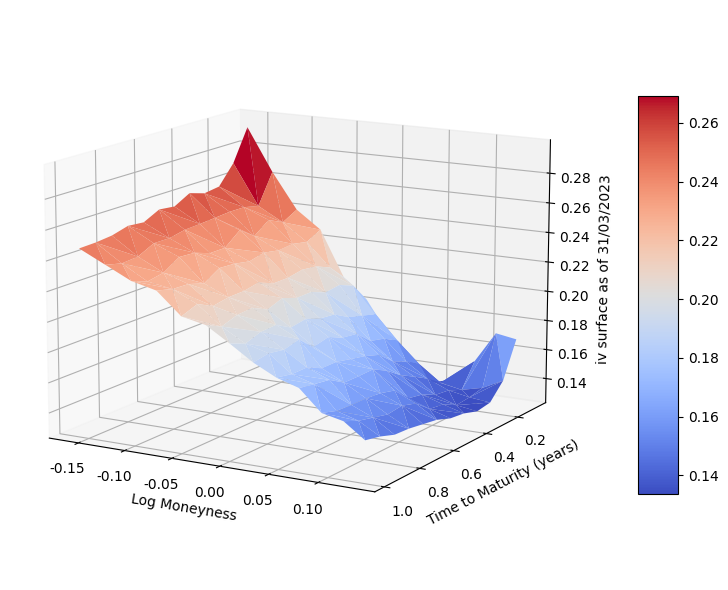

In [5]:
testdf = pd.DataFrame()
testdf['Moneyness'] = strikes/spot
testdf['Log Moneyness'] = np.log(strikes/spot)
testdf['Time to Maturity (years)'] = daysaddasint/365.0
testdf['iv surface as of 31/03/2023'] = implied_vols
plot_iv_surface(testdf, z='iv surface as of 31/03/2023')


In [6]:
volmatrix1 = volmatrix
for maturity in volmatrix1.columns:
    smile = volmatrix1[maturity]
    if not np.all(np.diff(smile) >= 0):
        sorted_smile = smile.sort_index()
        sorted_smile.interpolate(method='pchip', inplace=True)
        volmatrix1[maturity] = sorted_smile

#unused interpolation to find outliers

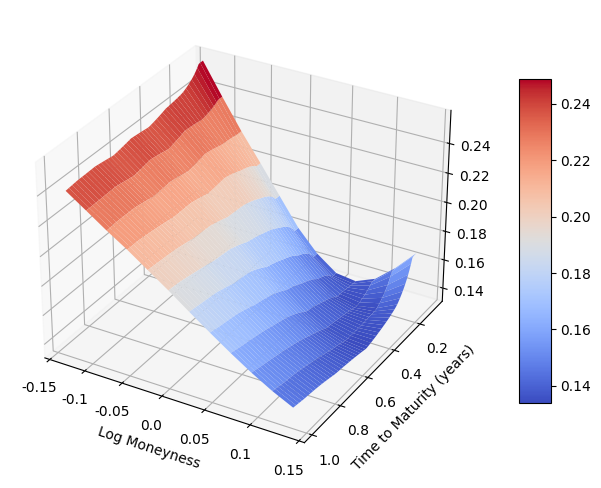

In [7]:
for i in range(rows):
    for j in range(cols):
        value = volmatrix.iloc[i, j]
        if not np.isnan(value):
            implied_vola[i][j] = value
        else:
            implied_vola[i][j] = np.nan

dates_unique = sorted(np.unique(volmatrix.columns))

strikes_unique = sorted(volmatrix.index.astype(float))



black_var_surface = ql.BlackVarianceSurface(referenceDate=calculation_date, cal=calendar, dates = dates_unique, strikes = strikes_unique, blackVols=implied_vola, dayCounter=day_count)
#black_var_surface.setInterpolation("bilinear")
black_var_surface.enableExtrapolation()
plot_vol_surface(black_var_surface)

In [8]:
day,year,month

(31, 2023, 3)

In [9]:
spot_quote = ql.QuoteHandle(ql.SimpleQuote(spot))

black_var_surface.setInterpolation("bilinear")
local_vol_handle = ql.BlackVolTermStructureHandle(black_var_surface)
# local_vol = ql.LocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote)
illegalVolOverride = 0.01
local_vol = ql.NoExceptLocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote, illegalVolOverride)
local_vol.enableExtrapolation()

#plot_vol_surface(local_vol, funct='localVol')

<b>Heston surface as of 31/03/2023 for calibrated parameters</b>

In [10]:
#overwritten plot function with changed colors
def plot_vol_surface(vol_surface, funct='blackVol'):
    if type(vol_surface) != list:
        surfaces = [vol_surface]
    else:
        surfaces = vol_surface

    plot_years = np.arange(max(daysaddasint_unique)/365.0, min(daysaddasint_unique)/365.0, -0.01) # Values in descending order
    plot_strikes = np.arange(max(strikes_unique), min(strikes_unique), -100) # Values in ascending order


    fig = plt.figure(figsize=(12, 6))


    ax = plt.subplot(111, projection='3d')

    X, Y = np.meshgrid(plot_strikes, plot_years)
   

    for surface in surfaces:
        method_to_call = getattr(surface, funct)

        Z = np.array([method_to_call(float(y), float(x)) 
                      for xr, yr in zip(X, Y) 
                      for x, y in zip(xr, yr)]
                    ).reshape(X.shape[0], X[0].size)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1)


   
    logmoneyness = np.round(np.arange(-0.15, 0.16, 0.05),2)
    strikepoints = np.exp(logmoneyness)*spot
    #replace the lables at the x-axis with the strikes divided by moneynes but keep the lables at original position
    ax.set_xticks(strikepoints,logmoneyness)
    #set axis titles
    ax.set_xlabel('Log Moneyness')
    ax.set_ylabel('Time to Maturity (years)')    

    
    #ax.elev = 13
    
    plt.tight_layout()
    ax.invert_yaxis()  # Invert the y-axis to display values ascending from left to right
    plt.show()

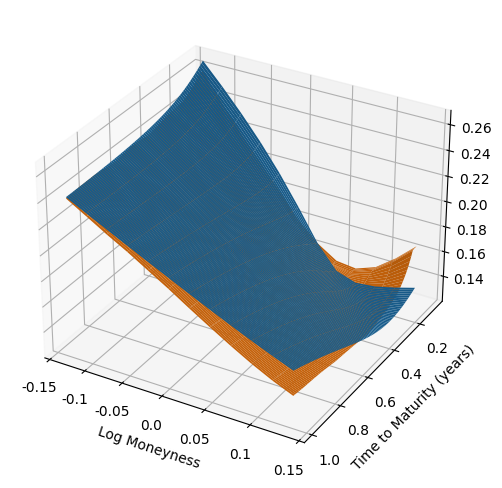

In [11]:
# Create new heston model
#3.157794199	0.058888761	1.039195463	-0.759985643	0.029351198

kappa = 3.157794199; theta = 0.058888761; sigma = 1.039195463; rho = -0.759985643; v0 = 0.029351198

feller = 2 * kappa * theta - sigma ** 2

heston_process = ql.HestonProcess(flat_ts, dividend_ts, spot_quote, v0, kappa, theta, sigma, rho)
heston_model = ql.HestonModel(heston_process)

# How does the vol surface look at the moment?
heston_handle = ql.HestonModelHandle(heston_model)
heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)
# Plot the vol surface ...
plot_vol_surface([heston_vol_surface, black_var_surface])


<b>Monte Carlo simulation to calibrate Leverage Function L(S,t)</b>

Paths: 1024
calibration took 1.7 seconds


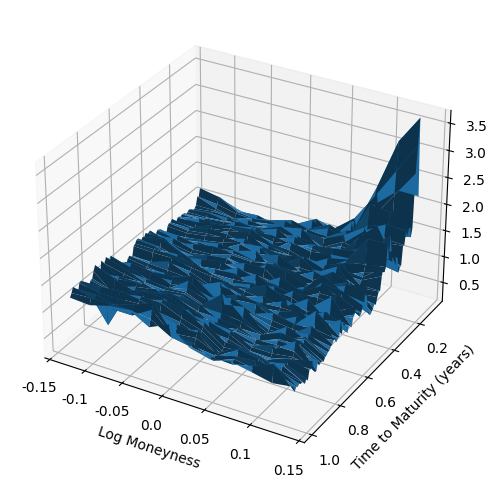

Paths: 4096
calibration took 3.3 seconds


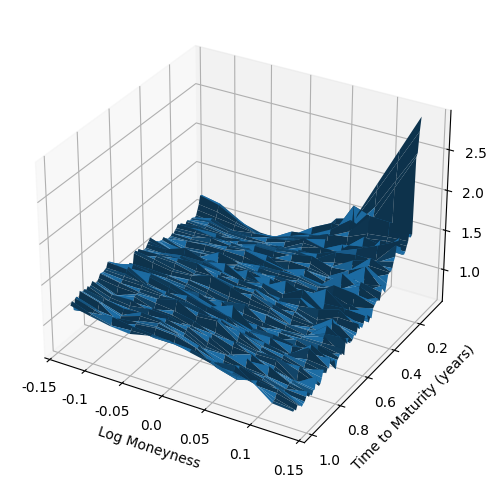

In [12]:
import time
end_date = calendar.advance(calculation_date, ql.Period(2, ql.Years))
generator_factory = ql.MTBrownianGeneratorFactory(43)

calibration_paths_vars = [2**10, 2**12]#    they take much time: , 2**19, 2**20]
time_steps_per_year, n_bins = 252,30

for calibration_paths in calibration_paths_vars:
    print("Paths: {}".format(calibration_paths))
    stoch_local_mc_model = ql.HestonSLVMCModel(local_vol, heston_model, generator_factory, end_date, time_steps_per_year, n_bins, calibration_paths)

    a = time.time()
    leverage_functon = stoch_local_mc_model.leverageFunction()
    b = time.time()

    print("calibration took {0:2.1f} seconds".format(b-a))
    plot_vol_surface(leverage_functon, funct='localVol')
    plt.pause(0.05)

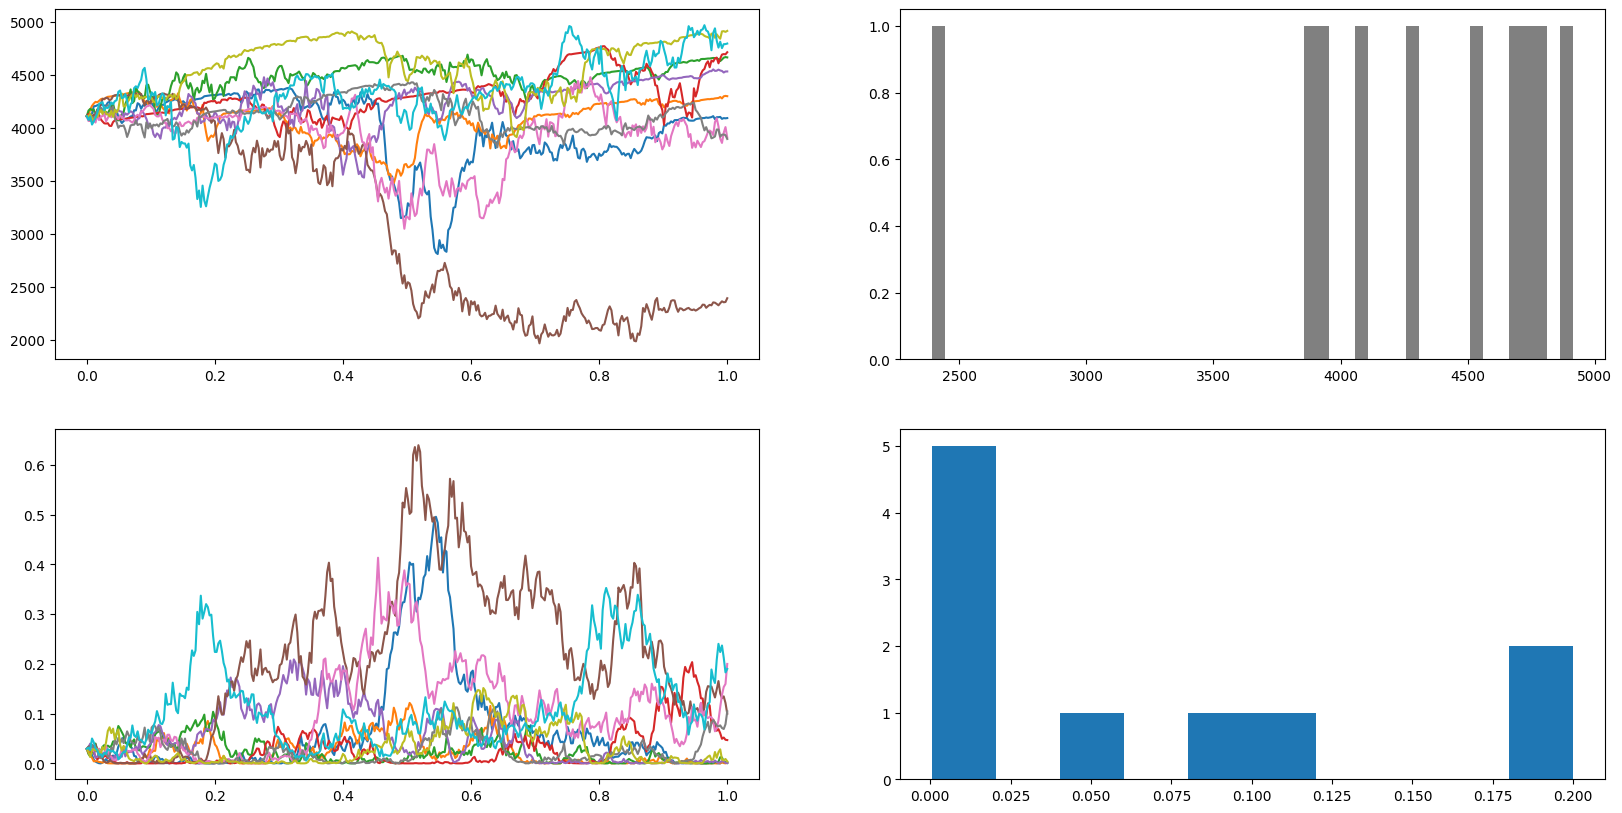

In [20]:
num_paths = 10
timestep = 365
length = 1
times = ql.TimeGrid(length, timestep)

stoch_local_process = ql.HestonSLVProcess(heston_process, leverage_functon)
dimension = stoch_local_process.factors()

rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(dimension * timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianMultiPathGenerator(stoch_local_process, list(times), rng, False)

df_spot, df_vol = generate_multi_paths_df(seq, num_paths)

fig = plt.figure(figsize=(20,10))

plt.subplot(2, 2, 1)
plt.plot(df_spot.iloc[0:10].transpose())

plt.subplot(2, 2, 2)
plt.hist(df_spot[1.0], color='grey', bins=50)

plt.subplot(2, 2, 3)
plt.plot(df_vol.iloc[0:10].transpose())

plt.subplot(2, 2, 4)
plt.hist(df_vol[1.0])

plt.show()

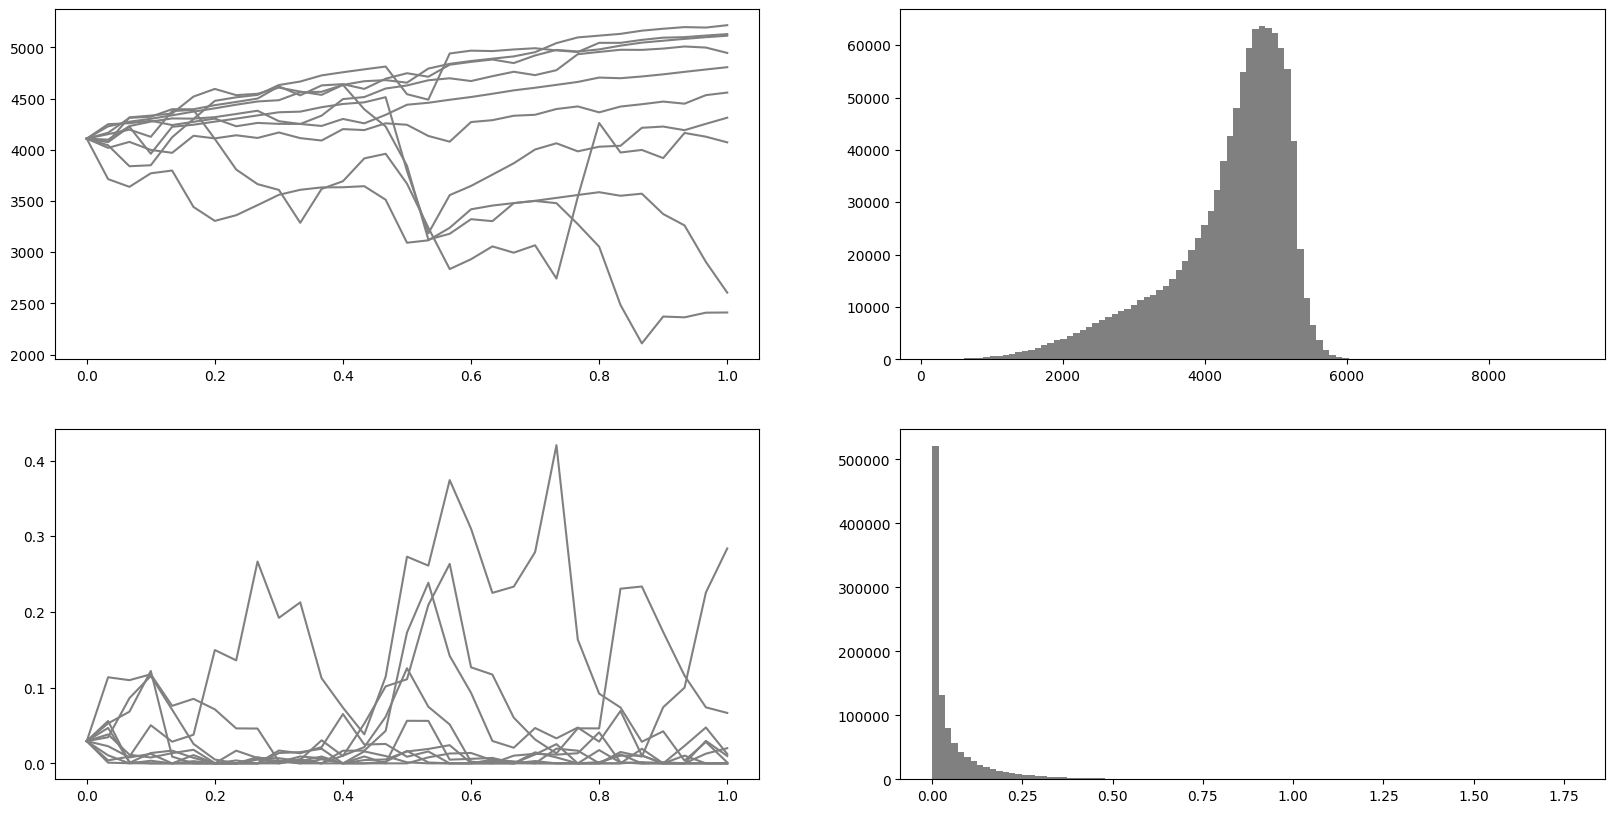

In [18]:
fig = plt.figure(figsize=(20,10))

plt.subplot(2, 2, 1)
plt.plot(df_spot.iloc[0:10].transpose(), color='grey')

plt.subplot(2, 2, 2)
plt.hist(df_spot[1.0], color='grey', bins=100)

plt.subplot(2, 2, 3)
plt.plot(df_vol.iloc[0:10].transpose(), color='grey')

plt.subplot(2, 2, 4)
plt.hist(df_vol[1.0], bins=100, color = 'grey')

plt.show()

In [19]:
spot

4109